In [1]:
import numpy as np
import _pickle as cp
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt

In [2]:
class NBC:
    def __init__(self, feature_types, num_classes, alpha):
        assert(len(feature_types)>0)
        assert(num_classes>1)
        self.feature_types = feature_types
        self.num_classes = num_classes
        self.alpha = alpha
    
    def _musigma(self, X):
        mu = np.mean(X)
        sigma = np.sqrt(np.var(X))
        if sigma==0:
            sigma = 1e-6
#         print(mu,sigma)
        return (mu,sigma)
    
    def _gaussian_fit(self, X_real, y):
#         print("Gaussian Fit")
        features = []
        for i in range(0, self.num_classes):
#             print(i)
#             print(X_real[y==i])
            features.append(self._musigma(X_real[y==i]))
        return features
    
    def _class_counts(self, X):
        unique_counts = np.unique(X, return_counts=True)
        class_counts = []
        for i in range(len(unique_counts[0])):
            class_counts.append((unique_counts[0][i],unique_counts[1][i]/X.shape[0]))
#         print(class_counts)
        return class_counts
    
    def _bernoulli_fit(self, X_class, y):
        features = []
        for i in range(0, self.num_classes):
            features.append(self._class_counts(X_class[y==i]))
        return features
    
    def fit(self, X, y):
        self.feature_params = []
        for i, feature_type in enumerate(self.feature_types):
            if feature_type == 'r':
                self.feature_params.append(self._gaussian_fit(X[:,i], y))
            elif feature_type == 'm' or feature_type == 'b':
#                 print(i)
                self.feature_params.append(self._bernoulli_fit(X[:,i], y))
        self.class_prior = []
        
        for class_label in range(self.num_classes):
            self.class_prior.append(np.size(y[y==class_label])/y.shape[0])
        
        return self.feature_params, self.class_prior
    
    def _gaussian_predict(self, X, features):
        mu,sigma = features
#         print(mu,sigma)
        prob = -0.5*((((X-mu)/sigma)**2)+np.log(sigma**2*2.*np.pi))
        return prob
    
    def _bernoulli_predict(self, X, features):
        log_prob = np.zeros(X.shape[0])
        
        for feature in features:
            log_prob[X==feature[0]] = np.log(feature[1]+self.alpha)
        
        log_prob[log_prob==0] = np.log(self.alpha)
        return log_prob
            
    
    def predict(self, X):
        shape = (X.shape[0], self.num_classes)
        self.preds = np.zeros(shape)
        for label in range(self.num_classes):
            pred_label = np.zeros(X.shape[0])
            for i, feature_type in enumerate(self.feature_types):
                #print("Return Value")
                if feature_type == 'r':
#                     print(np.log(self.class_prior[label]))
                    return_val = self._gaussian_predict(X[:,i], self.feature_params[i][label])
                    #print(return_val)
                    pred_label += return_val
                elif feature_type == 'm' or feature_type == 'b':
                    return_val = self._bernoulli_predict(X[:,i], self.feature_params[i][label])
                    #print(return_val)
                    pred_label += return_val
                #print("Pred_label")
                #print(pred_label)
            self.preds[:,label] = pred_label + np.log(self.class_prior[label])
        #print(self.preds)
        return np.argmax(self.preds, axis = 1)
    
    def accuracy(self, X_test, y_test):
        return np.mean(self.predict(X_test) == y_test)

In [3]:
def logistic_regression(X_train, y_train, X_test, y_test):
    lr = LogisticRegression(C=10)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    accuracy = np.mean(y_pred==y_test)
    return accuracy

def naive_bayes(X_train, y_train, X_test, y_test, feature_types, num_classes, alpha):
    nbc = NBC(feature_types, num_classes, alpha)
    nbc.fit(X_train, y_train)
    acc = nbc.accuracy(X_test, y_test)
#     print(acc)
    return acc

In [4]:
def data_loader(name):
    if name=="iris":
        iris = load_iris()
        X, y = iris['data'], iris['target']
        return X, y
    elif name == "voter":
        X,y = cp.load(open("data/voting.pickle","rb"))
        return X,y
    elif name == "voter-full":
        X,y = cp.load(open("data/voting-full.pickle","rb"))
        for i in range(X.shape[1]):
            col = X[:,i]
            print("There are "+str(np.size(col[col==2]))+" unknowns in column "+str(i))
        print("There are "+str(np.size(y[y==2]))+" unknowns in y")
        operation = input("Given above data what would you like to do? Same/Impute with Mean/Always zero ")
        if operation == 'Same' or operation == '1':
            return X, y
        elif operation == 'Impute with Mean' or operation == '2':
            for i in range(X.shape[1]):
                col = X[:,i]
                col[col==2] = np.mean(col[col!=2])
                X[:,i] = col
            return X, y
        elif operation == 'Always zero' or operation == '3':
            for i in range(X.shape[1]):
                col = X[:,i]
                col[col==2] = 0
                X[:,i] = col
            return X, y
        else:
            print("Invalid operation chosen, original matrix returned")
            return X,y

def get_permutation(X, y, k):
    N, D = X.shape
    train_size = int(0.8*N)
    shuffle = np.random.permutation(N)
    X_train = X[shuffle[:int(train_size*k/10)]]
    y_train = y[shuffle[:int(train_size*k/10)]]
    X_test = X[shuffle[int(train_size*k/10):]]
    y_test = y[shuffle[int(train_size*k/10):]]
    
    return X_train, y_train, X_test, y_test
    
def main():
    name = input("Enter the dataset name: ")
    if name == 'iris':
        X, y = data_loader("iris")
        feature_types = ['r','r','r','r']
        num_classes = 3
    elif name == 'voter':
        X, y = data_loader("voter")
#         print(X, y)
        feature_types = ['b' for i in range(X.shape[1])]
        num_classes = 2
    elif name == 'voter-full':
        X, y = data_loader("voter-full")
        feature_types = ['m' for i in range(X.shape[1])]
        num_classes = 2
    
    alpha = 0.01
    accuracy_nb = []
    accuracy_lr = []
    for k in range(1,11):
        acc_nb_val = 0
        acc_lr_val = 0
        for _ in range(0,200):
            X_train, y_train, X_test, y_test = get_permutation(X, y, k)
            acc_nb_val += naive_bayes(X_train, y_train, X_test, y_test, feature_types, num_classes, alpha)
            acc_lr_val += logistic_regression(X_train, y_train, X_test, y_test)
        accuracy_nb.append(acc_nb_val*0.005)
        accuracy_lr.append(acc_lr_val*0.005)
    
    print(accuracy_nb)
    print(accuracy_lr)
    plt.plot(range(1,11), accuracy_nb, 'r', label = 'Naive Bayes')
    plt.plot(range(1,11), accuracy_lr, 'b', label = 'Logistic Regression')
    plt.xlabel('Train size')
    plt.ylabel('Test Accuracy')
    plt.title('Train Size vs Test Accuracy')
    plt.show()
    print("Done")
    return
    
    

Enter the dataset name: iris


C:\Users\dell\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\dell\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\dell\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3126: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\dell\Anaconda3\lib\site-packages\numpy\core\_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\dell\Anaconda3\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\dell\Anaconda3\lib\site-packages\ipykernel\__main__.py:89: RuntimeWarning: divide by zero encountered in log


[0.7815217391304351, 0.93559523809523815, 0.94390350877193119, 0.94901960784313633, 0.95211111111111124, 0.94942307692307681, 0.95227272727272838, 0.95370370370370483, 0.95309523809523944, 0.95150000000000168]
[0.84355072463768255, 0.91722222222222305, 0.93916666666666826, 0.94749999999999945, 0.95077777777777761, 0.95237179487179435, 0.95886363636363781, 0.95657407407407524, 0.95833333333333415, 0.95983333333333454]


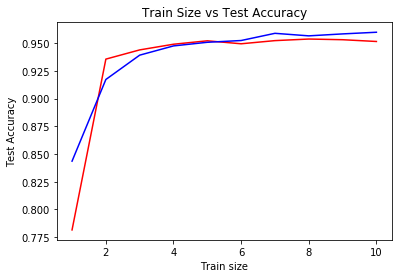

Done


In [5]:
main()

Enter the dataset name: voter
[0.89612149532710283, 0.90538461538461412, 0.90723163841807908, 0.90920886075949403, 0.90835714285714153, 0.91012396694214948, 0.91024271844660198, 0.90934523809523682, 0.9097727272727274, 0.91127659574468001]
[0.91030373831775746, 0.93607692307692247, 0.94426553672316471, 0.95047468354430498, 0.95235714285714168, 0.95338842975206617, 0.95708737864077675, 0.95607142857142946, 0.95606060606060772, 0.95670212765957308]


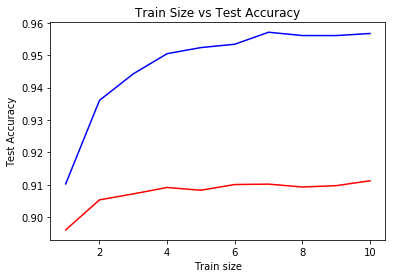

Done


In [6]:
main()

Enter the dataset name: voter-full
There are 12 unknowns in column 0
There are 48 unknowns in column 1
There are 11 unknowns in column 2
There are 11 unknowns in column 3
There are 15 unknowns in column 4
There are 11 unknowns in column 5
There are 14 unknowns in column 6
There are 15 unknowns in column 7
There are 22 unknowns in column 8
There are 7 unknowns in column 9
There are 21 unknowns in column 10
There are 31 unknowns in column 11
There are 25 unknowns in column 12
There are 17 unknowns in column 13
There are 28 unknowns in column 14
There are 104 unknowns in column 15
There are 0 unknowns in y
Given above data what would you like to do? Same/Impute with Mean/Always zero 1
[0.8971695760598507, 0.89886612021857915, 0.90086102719033012, 0.90030405405405423, 0.89959770114942628, 0.90008810572687226, 0.89971354166666684, 0.89875796178343925, 0.90065573770491814, 0.90385057471264418]
[0.90743142144638356, 0.92199453551912525, 0.92595166163141829, 0.93104729729729674, 0.931206896551

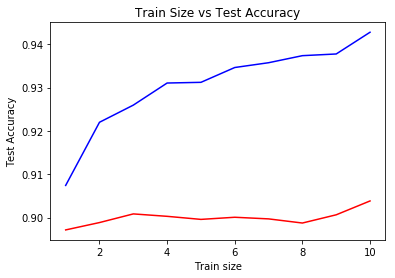

Done


In [7]:
main()

Enter the dataset name: voter-full
There are 12 unknowns in column 0
There are 48 unknowns in column 1
There are 11 unknowns in column 2
There are 11 unknowns in column 3
There are 15 unknowns in column 4
There are 11 unknowns in column 5
There are 14 unknowns in column 6
There are 15 unknowns in column 7
There are 22 unknowns in column 8
There are 7 unknowns in column 9
There are 21 unknowns in column 10
There are 31 unknowns in column 11
There are 25 unknowns in column 12
There are 17 unknowns in column 13
There are 28 unknowns in column 14
There are 104 unknowns in column 15
There are 0 unknowns in y
Given above data what would you like to do? Same/Impute with Mean/Always zero 2
[0.89783042394015, 0.90036885245901599, 0.89954682779455986, 0.90037162162162165, 0.90034482758620726, 0.9000660792951547, 0.89966145833333377, 0.90012738853503138, 0.89987704918032663, 0.89747126436781643]
[0.92885286783042387, 0.94519125683060123, 0.94978851963746092, 0.95347972972972983, 0.955919540229885

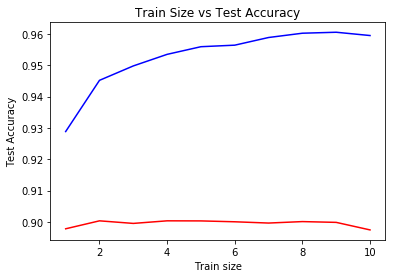

Done


In [8]:
main()

Enter the dataset name: voter-full
There are 12 unknowns in column 0
There are 48 unknowns in column 1
There are 11 unknowns in column 2
There are 11 unknowns in column 3
There are 15 unknowns in column 4
There are 11 unknowns in column 5
There are 14 unknowns in column 6
There are 15 unknowns in column 7
There are 22 unknowns in column 8
There are 7 unknowns in column 9
There are 21 unknowns in column 10
There are 31 unknowns in column 11
There are 25 unknowns in column 12
There are 17 unknowns in column 13
There are 28 unknowns in column 14
There are 104 unknowns in column 15
There are 0 unknowns in y
Given above data what would you like to do? Same/Impute with Mean/Always zero 3
[0.89948877805486249, 0.89838797814207638, 0.89820241691842684, 0.89565878378378327, 0.89386973180076656, 0.89596916299559537, 0.89630208333333361, 0.89789808917197445, 0.89754098360655632, 0.89402298850574757]
[0.92790523690773097, 0.94228142076502763, 0.94728096676737039, 0.95084459459459514, 0.95337164750

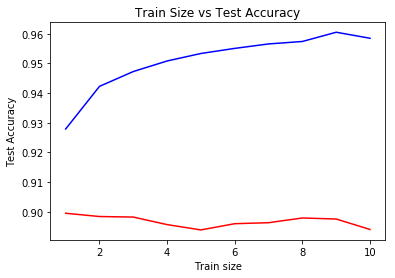

Done


In [9]:
main()